In [53]:
import cellxgene_census
import torch

import cellxgene_census.experimental.ml as census_ml
import tiledbsoma as soma
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [12]:
census = cellxgene_census.open_soma()

The "stable" release is currently 2024-07-01. Specify 'census_version="2024-07-01"' in future calls to open_soma() to ensure data consistency.


In [27]:
experiment = census["census_data"]["homo_sapiens"]

experiment_datapipe = census_ml.ExperimentDataPipe(
    experiment,
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'tongue' and is_primary_data == True"),
    obs_column_names=["cell_type"],
    batch_size=124,
    shuffle=True,
    soma_chunk_size=10_000,
)

In [28]:
experiment_datapipe.shape

(15020, 60530)

In [29]:
train_datapipe, test_datapipe = experiment_datapipe.random_split(weights={"train": 0.8, "test": 0.2}, seed=1)

train_dataloader = census_ml.experiment_dataloader(train_datapipe)
test_dataloader = census_ml.experiment_dataloader(test_datapipe)

In [30]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [50]:
def train_epoch(model, train_dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.float().to(device)

        # Perform prediction
        outputs = model(X_batch)

        # Determine the predicted label
        probabilities = torch.nn.functional.softmax(outputs, 1)
        predictions = torch.argmax(probabilities, axis=1)

        # Compute the loss and perform back propagation

        y_batch = y_batch.flatten()
        y_batch = y_batch.to(device)

        train_correct += (predictions == y_batch).sum().item()
        train_total += len(predictions)

        loss = loss_fn(outputs, y_batch.long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= train_total
    train_accuracy = train_correct / train_total
    return train_loss, train_accuracy


def test_epoch(model, test_dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            X_batch, y_batch = batch

            X_batch = X_batch.float().to(device)

            # Perform prediction
            outputs = model(X_batch)

            # Determine the predicted label
            probabilities = torch.nn.functional.softmax(outputs, 1)
            predictions = torch.argmax(probabilities, axis=1)

            # Compute the loss
            y_batch = y_batch.flatten()
            y_batch = y_batch.to(device)

            test_correct += (predictions == y_batch).sum().item()
            test_total += len(predictions)

            loss = loss_fn(outputs, y_batch.long())
            test_loss += loss.item()

    test_loss /= test_total
    test_accuracy = test_correct / test_total
    return test_loss, test_accuracy

In [51]:
def plot_learning_curves(training_losses, validation_losses):
    clear_output(wait=True)

    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

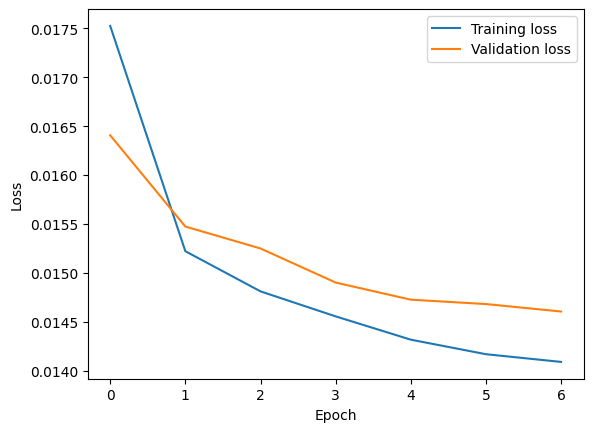

Epoch 6: Train Loss= 0.0141, Test Loss= 0.0146, Train Accuracy= 0.5959, Test Accuracy= 0.5869


KeyboardInterrupt: 

In [54]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# The size of the input dimension is the number of genes
input_dim = experiment_datapipe.shape[1]

# The size of the output dimension is the number of distinct cell_type values
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]
output_dim = len(cell_type_encoder.classes_)

model = LogisticRegression(input_dim, output_dim).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05)

training_losses = []
test_losses = []
for epoch in range(10):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_epoch(model, test_dataloader, loss_fn, device)

    training_losses.append(train_loss)
    test_losses.append(test_loss)

    plot_learning_curves(training_losses, test_losses)
    print(f'Epoch {epoch}: Train Loss= {train_loss:.4f}, Test Loss= {test_loss:.4f}, Train Accuracy= {train_accuracy:.4f}, Test Accuracy= {test_accuracy:.4f}') 

In [33]:
X_batch, y_batch = next(iter(test_dataloader))

In [34]:
model.eval()

model.to(device)
outputs = model(X_batch.to(device))

probabilities = torch.nn.functional.softmax(outputs, 1)
predictions = torch.argmax(probabilities, axis=1)

display(predictions)

tensor([ 6, 11,  5,  5,  1,  8,  1,  1,  1,  7,  1,  7,  1,  8,  1,  5,  5,  1,
         7,  1,  7,  7,  7,  5,  7,  8,  8,  1,  7,  5,  1,  5,  1,  7,  7,  8,
         1,  8,  1,  1,  8,  1,  1,  1,  5,  7,  1,  1,  7, 11,  8,  1,  5,  5,
        11,  1,  1,  1,  1,  1,  8,  8,  5,  5,  1,  1,  1,  7,  5,  1,  7,  1,
         1,  1,  8,  8,  7,  9,  5,  7,  7,  1,  1,  5,  8,  8,  1,  1,  1,  7,
         8,  5,  1,  1,  1,  1,  1,  8,  5,  1,  8,  1,  5,  7,  9,  5,  1,  7,
         1,  1,  7,  5,  7,  1,  7,  1,  7,  1,  5,  1,  5,  7,  1,  1])

In [35]:
cell_type_encoder = experiment_datapipe.obs_encoders["cell_type"]

predicted_cell_types = cell_type_encoder.inverse_transform(predictions.cpu())

display(predicted_cell_types)

array(['fibroblast', 'vein endothelial cell', 'epithelial cell',
       'epithelial cell', 'basal cell', 'leukocyte', 'basal cell',
       'basal cell', 'basal cell', 'keratinocyte', 'basal cell',
       'keratinocyte', 'basal cell', 'leukocyte', 'basal cell',
       'epithelial cell', 'epithelial cell', 'basal cell', 'keratinocyte',
       'basal cell', 'keratinocyte', 'keratinocyte', 'keratinocyte',
       'epithelial cell', 'keratinocyte', 'leukocyte', 'leukocyte',
       'basal cell', 'keratinocyte', 'epithelial cell', 'basal cell',
       'epithelial cell', 'basal cell', 'keratinocyte', 'keratinocyte',
       'leukocyte', 'basal cell', 'leukocyte', 'basal cell', 'basal cell',
       'leukocyte', 'basal cell', 'basal cell', 'basal cell',
       'epithelial cell', 'keratinocyte', 'basal cell', 'basal cell',
       'keratinocyte', 'vein endothelial cell', 'leukocyte', 'basal cell',
       'epithelial cell', 'epithelial cell', 'vein endothelial cell',
       'basal cell', 'basal cell'

In [36]:
import pandas as pd

display(
    pd.DataFrame(
        {
            "actual cell type": cell_type_encoder.inverse_transform(y_batch.ravel().numpy()),
            "predicted cell type": predicted_cell_types,
        }
    )
)

,actual cell type,predicted cell type
0,fibroblast,fibroblast
1,endothelial cell of lymphatic vessel,vein endothelial cell
2,epithelial cell,epithelial cell
3,epithelial cell,epithelial cell
4,basal cell,basal cell
...,...,...
119,basal cell,basal cell
120,epithelial cell,epithelial cell
121,keratinocyte,keratinocyte
122,basal cell,basal cell


In [47]:
# calculate the accuracy
correct = (predictions.numpy() == y_batch.ravel().numpy()).sum().item()
total = len(predictions)
accuracy = correct / total

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9435


In [37]:
census.close()